In [184]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [185]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)

# load hydro inflow in Austria
df_hydro = pd.read_csv('data/Hydro_Inflow_AT.csv')  # assumes columns: Year, Month, Day, Inflow [GWh]
df_hydro['date'] = pd.to_datetime(df_hydro[['Year', 'Month', 'Day']])
df_hydro.set_index('date', inplace=True)

# Convert from GWh/day → MW (spread evenly across 24 hours)
df_hydro['inflow_MW'] = df_hydro['Inflow [GWh]'] * 1000 / 24
## Align to model snapshots
df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

df_hydro_inflow = pd.DataFrame(index=hours_in_2015)
df_hydro_inflow['inflow_MW'] = df_hydro_hourly.loc[df_hydro_hourly.index.year==2011].values

<>:14: DeprecationWarning: invalid escape sequence '\p'
<>:18: DeprecationWarning: invalid escape sequence '\p'
<>:14: DeprecationWarning: invalid escape sequence '\p'
<>:18: DeprecationWarning: invalid escape sequence '\p'
C:\Users\alexk\AppData\Local\Temp\ipykernel_38936\3096401804.py:14: DeprecationWarning: invalid escape sequence '\p'
  df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_38936\3096401804.py:18: DeprecationWarning: invalid escape sequence '\p'
  df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_38936\3096401804.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


In [186]:
colors = {"onshore": "blue", "offshore": "darkblue", "pv": "orange", 
          "rooftop": "yellow", "coal": "brown", "OCGT": "grey"}

# __F.__ Make Network

In [187]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [188]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015.values)

# add the different carriers, only gas emits CO2
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "solarPV")
n.add("Carrier", "rooftopPV")
n.add("Carrier", "hydro")

countries = ['DEU', 'DNK', 'AUT']
coordinates = {'DNK': (55.67, 12.57), # Copenhagen
                'DEU': (52.37, 9.73), # Hannover
                'AUT': (47.57, 14.23)} # Liezen

# add electricity bus
for country in countries:
    n.add("Bus",
                country,
                y = coordinates[country][0],
                x = coordinates[country][1],
                carrier="AC",)

    # add load to the bus
    n.add("Load",
                f"load{country}",
                bus=country,
                p_set=df_elec[country].values)


    ''' Add renewable generators '''
    if country != 'AUT':
        # Add onshore wind
        CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 30 # years
        discount_rate = 0.07 # 7%
        capex = 910000 # in €/MW
        fopex = 0.033 # 3.3% of capex
        capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"onshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="onshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_onshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_onshore.values)

        # Add offshore wind
        CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 2506000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"offshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="offshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_offshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_offshore.values)

    # Add large scale solar
    CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 425000 # in €/MW
    fopex = 0.03 # 3% of capex
    capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    n.add("Generator",
                f"PV{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="solarPV",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_pv,
                marginal_cost = 0,
                p_max_pu = CF_solar.values)



    ''' Add non-renewables generators '''
    # add OCGT (Open Cycle Gas Turbine) generator
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 560000 # in €/MW
    fopex = 0.033 # 3.3% of capex
    capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    fuel_cost = 21.6 # in €/MWh_th
    efficiency = 0.39 # MWh_elec/MWh_th
    marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
    n.add("Generator",
                f"OCGT{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="gas",
                #p_nom_max=1000,
                capital_cost = capital_cost_OCGT,
                efficiency = efficiency,
                marginal_cost = marginal_cost_OCGT)

    if country == 'DEU':
        # add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 3294000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        fuel_cost = 4 # in €/MWh_th 
        efficiency = 0.36 # MWh_elec/MWh_th
        marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
        n.add("Generator",
                    f"coal{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="coal",
                    #p_nom_max=1000,
                    capital_cost = capital_cost_coal,
                    efficiency = efficiency,
                    marginal_cost = marginal_cost_coal)
        
    if country == 'AUT':
        lifetime = 80 # years
        discount_rate = 0.07 # 7%
        capex = 300000 # in €/MW
        fopex = 0.02 # 2% of capex
        capital_cost_hydro = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        marginal_cost_hydro = 0

        n.add("StorageUnit",
            name=f"hydro{country}",
            bus=country,
            p_nom_extendable=True,
            capital_cost=capital_cost_hydro,
            marginal_cost=0,
            efficiency_store=1.0,       # inflow enters fully
            efficiency_dispatch=0.9,    # turbine efficiency
            max_hours=2000,             # max energy storage in MWh per MW of power capacity
            inflow=df_hydro_inflow.values.flatten(),  # energy inflow time series in MW
            carrier="hydro")

'''
    # Add storage unit
    n.add("StorageUnit",
                f"battery{country}",
                bus=country,
                p_nom_extendable=True,
                capital_cost=12894+24678,
                efficiency_dispatch=0.96,
                efficiency_store=0.96,
                max_hours=2,
                cyclic_state_of_charge=True)
    


'''

'\n    # Add storage unit\n    n.add("StorageUnit",\n                f"battery{country}",\n                bus=country,\n                p_nom_extendable=True,\n                capital_cost=12894+24678,\n                efficiency_dispatch=0.96,\n                efficiency_store=0.96,\n                max_hours=2,\n                cyclic_state_of_charge=True)\n    \n\n\n'

In [189]:
# Add AC lines between the countries
distances = {
    ("DEU", "DNK"): 406, # km
    ("DEU", "AUT"): 622, # km
    ("DNK", "AUT"): 909, # km
}

capital_cost_lines = 400 # in €/MW/km

n.add(
    "Line",
    "DEU-DNK",
    bus0="DEU",
    bus1="DNK",
    s_nom = 2500,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "DNK")],
    #s_nom_extendable = True
)

n.add(
    "Line",
    "DEU-AUT",
    bus0="DEU",
    bus1="AUT",
    s_nom = 6500,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "AUT")],
    #s_nom_extendable = True
)

'''
n.add(
    "Line",
    "DNK-AUT",
    bus0="DNK",
    bus1="AUT",
    s_nom = 300,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DNK", "AUT")],
    #s_nom_extendable = True
)
'''

'\nn.add(\n    "Line",\n    "DNK-AUT",\n    bus0="DNK",\n    bus1="AUT",\n    s_nom = 300,\n    x = 1,\n    r = 1,\n    #capital_cost = capital_cost_lines * distances[("DNK", "AUT")],\n    #s_nom_extendable = True\n)\n'

In [190]:
n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
DEU-DNK,DEU,DNK,,1.0,1.0,0.0,0.0,2500.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEU-AUT,DEU,AUT,,1.0,1.0,0.0,0.0,6500.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\alexk\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x22741cf8e10>,
 <matplotlib.collections.LineCollection at 0x2272e339650>)

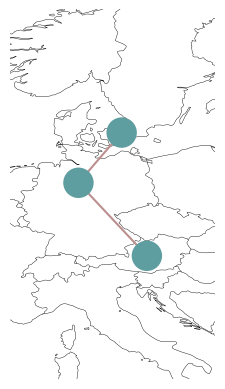

In [191]:
n.plot(bus_sizes=1, margin=1)

In [192]:

# Co2 Cap
CO2_limit = (596 + 27.3 + 58.6) #MtCO2

n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant= CO2_limit * 1000000, #596MtCO2 for GE + 4.6 for DK + 6.4 for AT
)


Index(['CO2Limit'], dtype='object')

In [203]:
n.optimize(solver_name='gurobi')


Index(['DEU', 'DNK', 'AUT'], dtype='object', name='Bus')


Index(['0'], dtype='object', name='SubNetwork')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 14.29it/s]
INFO:linopy.io: Writing time: 4.18s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-ml585t_1.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-ml585t_1.lp


Reading time = 1.22 seconds


INFO:gurobipy:Reading time = 1.22 seconds


obj: 315373 rows, 148932 columns, 617797 nonzeros


INFO:gurobipy:obj: 315373 rows, 148932 columns, 617797 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 315373 rows, 148932 columns and 617797 nonzeros


INFO:gurobipy:Optimize a model with 315373 rows, 148932 columns and 617797 nonzeros


Model fingerprint: 0x9cb739e9


INFO:gurobipy:Model fingerprint: 0x9cb739e9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 7e+08]


INFO:gurobipy:  RHS range        [1e+03, 7e+08]


Presolve removed 170626 rows and 12934 columns


INFO:gurobipy:Presolve removed 170626 rows and 12934 columns


Presolve time: 0.44s


INFO:gurobipy:Presolve time: 0.44s


Presolved: 144747 rows, 135998 columns, 434237 nonzeros


INFO:gurobipy:Presolved: 144747 rows, 135998 columns, 434237 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.14s


INFO:gurobipy:Ordering time: 0.14s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 12


INFO:gurobipy: Dense cols : 12


 AA' NZ     : 3.421e+05


INFO:gurobipy: AA' NZ     : 3.421e+05


 Factor NZ  : 2.581e+06 (roughly 130 MB of memory)


INFO:gurobipy: Factor NZ  : 2.581e+06 (roughly 130 MB of memory)


 Factor Ops : 5.270e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.270e+07 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.73954391e+13 -1.51931412e+12  3.84e+11 0.00e+00  6.79e+10     1s


INFO:gurobipy:   0   7.73954391e+13 -1.51931412e+12  3.84e+11 0.00e+00  6.79e+10     1s


   1   9.84524173e+13 -5.21933697e+12  9.00e+10 6.69e+02  1.56e+10     1s


INFO:gurobipy:   1   9.84524173e+13 -5.21933697e+12  9.00e+10 6.69e+02  1.56e+10     1s


   2   9.36319318e+13 -6.32111486e+12  8.80e+09 1.02e+02  2.22e+09     1s


INFO:gurobipy:   2   9.36319318e+13 -6.32111486e+12  8.80e+09 1.02e+02  2.22e+09     1s


   3   3.63519621e+13 -6.07258482e+12  5.64e+08 1.37e+01  2.86e+08     2s


INFO:gurobipy:   3   3.63519621e+13 -6.07258482e+12  5.64e+08 1.37e+01  2.86e+08     2s


   4   8.47961055e+12 -2.88650329e+12  7.37e+07 1.40e+00  4.69e+07     2s


INFO:gurobipy:   4   8.47961055e+12 -2.88650329e+12  7.37e+07 1.40e+00  4.69e+07     2s


   5   4.46619511e+12 -1.25178759e+12  3.68e+07 4.28e-01  2.09e+07     2s


INFO:gurobipy:   5   4.46619511e+12 -1.25178759e+12  3.68e+07 4.28e-01  2.09e+07     2s


   6   1.86088272e+12 -5.08264240e+11  1.41e+07 1.44e-01  8.09e+06     2s


INFO:gurobipy:   6   1.86088272e+12 -5.08264240e+11  1.41e+07 1.44e-01  8.09e+06     2s


   7   5.00592448e+11 -1.77833645e+11  2.84e+06 4.47e-02  2.19e+06     2s


INFO:gurobipy:   7   5.00592448e+11 -1.77833645e+11  2.84e+06 4.47e-02  2.19e+06     2s


   8   2.20849830e+11 -7.43291565e+10  1.93e+02 1.70e-02  9.16e+05     2s


INFO:gurobipy:   8   2.20849830e+11 -7.43291565e+10  1.93e+02 1.70e-02  9.16e+05     2s


   9   1.05878611e+11 -1.25597648e+09  7.23e+01 3.54e-04  3.20e+05     3s


INFO:gurobipy:   9   1.05878611e+11 -1.25597648e+09  7.23e+01 3.54e-04  3.20e+05     3s


  10   5.13134281e+10  1.42755960e+10  2.04e+01 1.86e-09  1.09e+05     3s


INFO:gurobipy:  10   5.13134281e+10  1.42755960e+10  2.04e+01 1.86e-09  1.09e+05     3s


  11   4.57139836e+10  1.87565682e+10  1.58e+01 4.05e-09  7.93e+04     3s


INFO:gurobipy:  11   4.57139836e+10  1.87565682e+10  1.58e+01 4.05e-09  7.93e+04     3s


  12   4.12612278e+10  2.13915984e+10  1.21e+01 1.76e-09  5.83e+04     3s


INFO:gurobipy:  12   4.12612278e+10  2.13915984e+10  1.21e+01 1.76e-09  5.83e+04     3s


  13   3.87744147e+10  2.37546028e+10  9.94e+00 3.22e-10  4.40e+04     3s


INFO:gurobipy:  13   3.87744147e+10  2.37546028e+10  9.94e+00 3.22e-10  4.40e+04     3s


  14   3.35858750e+10  2.52664568e+10  5.38e+00 3.30e-09  2.44e+04     4s


INFO:gurobipy:  14   3.35858750e+10  2.52664568e+10  5.38e+00 3.30e-09  2.44e+04     4s


  15   3.23366447e+10  2.58689131e+10  4.21e+00 1.94e-09  1.89e+04     4s


INFO:gurobipy:  15   3.23366447e+10  2.58689131e+10  4.21e+00 1.94e-09  1.89e+04     4s


  16   3.14800462e+10  2.61562057e+10  3.41e+00 1.06e-09  1.56e+04     4s


INFO:gurobipy:  16   3.14800462e+10  2.61562057e+10  3.41e+00 1.06e-09  1.56e+04     4s


  17   3.12418835e+10  2.64365216e+10  3.20e+00 1.55e-09  1.41e+04     4s


INFO:gurobipy:  17   3.12418835e+10  2.64365216e+10  3.20e+00 1.55e-09  1.41e+04     4s


  18   3.05636924e+10  2.67620087e+10  2.55e+00 8.69e-10  1.11e+04     4s


INFO:gurobipy:  18   3.05636924e+10  2.67620087e+10  2.55e+00 8.69e-10  1.11e+04     4s


  19   2.98818303e+10  2.70607284e+10  1.87e+00 1.05e-09  8.26e+03     5s


INFO:gurobipy:  19   2.98818303e+10  2.70607284e+10  1.87e+00 1.05e-09  8.26e+03     5s


  20   2.94451441e+10  2.73631265e+10  1.39e+00 1.12e-09  6.10e+03     5s


INFO:gurobipy:  20   2.94451441e+10  2.73631265e+10  1.39e+00 1.12e-09  6.10e+03     5s


  21   2.90808155e+10  2.74436250e+10  9.67e-01 6.96e-10  4.79e+03     5s


INFO:gurobipy:  21   2.90808155e+10  2.74436250e+10  9.67e-01 6.96e-10  4.79e+03     5s


  22   2.87929140e+10  2.77229557e+10  6.47e-01 6.80e-10  3.13e+03     5s


INFO:gurobipy:  22   2.87929140e+10  2.77229557e+10  6.47e-01 6.80e-10  3.13e+03     5s


  23   2.86033995e+10  2.78878046e+10  4.33e-01 1.71e-09  2.09e+03     6s


INFO:gurobipy:  23   2.86033995e+10  2.78878046e+10  4.33e-01 1.71e-09  2.09e+03     6s


  24   2.84308598e+10  2.79467257e+10  2.41e-01 6.48e-10  1.42e+03     6s


INFO:gurobipy:  24   2.84308598e+10  2.79467257e+10  2.41e-01 6.48e-10  1.42e+03     6s


  25   2.83818935e+10  2.80515073e+10  1.88e-01 1.01e-09  9.67e+02     6s


INFO:gurobipy:  25   2.83818935e+10  2.80515073e+10  1.88e-01 1.01e-09  9.67e+02     6s


  26   2.83507600e+10  2.80741005e+10  1.53e-01 7.69e-10  8.10e+02     6s


INFO:gurobipy:  26   2.83507600e+10  2.80741005e+10  1.53e-01 7.69e-10  8.10e+02     6s


  27   2.83179056e+10  2.81144956e+10  1.18e-01 1.54e-09  5.95e+02     7s


INFO:gurobipy:  27   2.83179056e+10  2.81144956e+10  1.18e-01 1.54e-09  5.95e+02     7s


  28   2.82970790e+10  2.81310143e+10  9.72e-02 6.69e-10  4.86e+02     7s


INFO:gurobipy:  28   2.82970790e+10  2.81310143e+10  9.72e-02 6.69e-10  4.86e+02     7s


  29   2.82762113e+10  2.81491736e+10  7.53e-02 6.72e-10  3.72e+02     7s


INFO:gurobipy:  29   2.82762113e+10  2.81491736e+10  7.53e-02 6.72e-10  3.72e+02     7s


  30   2.82640559e+10  2.81616607e+10  6.24e-02 3.45e-10  3.00e+02     7s


INFO:gurobipy:  30   2.82640559e+10  2.81616607e+10  6.24e-02 3.45e-10  3.00e+02     7s


  31   2.82522295e+10  2.81704794e+10  4.99e-02 2.31e-10  2.39e+02     8s


INFO:gurobipy:  31   2.82522295e+10  2.81704794e+10  4.99e-02 2.31e-10  2.39e+02     8s


  32   2.82429236e+10  2.81738659e+10  3.94e-02 4.94e-10  2.02e+02     8s


INFO:gurobipy:  32   2.82429236e+10  2.81738659e+10  3.94e-02 4.94e-10  2.02e+02     8s


  33   2.82352575e+10  2.81825212e+10  3.21e-02 7.83e-10  1.54e+02     8s


INFO:gurobipy:  33   2.82352575e+10  2.81825212e+10  3.21e-02 7.83e-10  1.54e+02     8s


  34   2.82302090e+10  2.81859817e+10  2.65e-02 5.64e-10  1.29e+02     8s


INFO:gurobipy:  34   2.82302090e+10  2.81859817e+10  2.65e-02 5.64e-10  1.29e+02     8s


  35   2.82269965e+10  2.81896712e+10  2.32e-02 6.14e-10  1.09e+02     9s


INFO:gurobipy:  35   2.82269965e+10  2.81896712e+10  2.32e-02 6.14e-10  1.09e+02     9s


  36   2.82260127e+10  2.81905064e+10  2.21e-02 6.03e-10  1.04e+02     9s


INFO:gurobipy:  36   2.82260127e+10  2.81905064e+10  2.21e-02 6.03e-10  1.04e+02     9s


  37   2.82232418e+10  2.81931049e+10  1.92e-02 1.30e-09  8.82e+01     9s


INFO:gurobipy:  37   2.82232418e+10  2.81931049e+10  1.92e-02 1.30e-09  8.82e+01     9s


  38   2.82181956e+10  2.81937447e+10  1.33e-02 8.16e-10  7.16e+01     9s


INFO:gurobipy:  38   2.82181956e+10  2.81937447e+10  1.33e-02 8.16e-10  7.16e+01     9s


  39   2.82163011e+10  2.81970504e+10  1.13e-02 2.61e-09  5.63e+01    10s


INFO:gurobipy:  39   2.82163011e+10  2.81970504e+10  1.13e-02 2.61e-09  5.63e+01    10s


  40   2.82132598e+10  2.81986751e+10  7.85e-03 1.93e-09  4.27e+01    10s


INFO:gurobipy:  40   2.82132598e+10  2.81986751e+10  7.85e-03 1.93e-09  4.27e+01    10s


  41   2.82118660e+10  2.81991810e+10  6.43e-03 3.01e-09  3.71e+01    10s


INFO:gurobipy:  41   2.82118660e+10  2.81991810e+10  6.43e-03 3.01e-09  3.71e+01    10s


  42   2.82110946e+10  2.81998184e+10  5.58e-03 2.39e-09  3.30e+01    10s


INFO:gurobipy:  42   2.82110946e+10  2.81998184e+10  5.58e-03 2.39e-09  3.30e+01    10s


  43   2.82103214e+10  2.82004053e+10  4.75e-03 2.58e-09  2.90e+01    10s


INFO:gurobipy:  43   2.82103214e+10  2.82004053e+10  4.75e-03 2.58e-09  2.90e+01    10s


  44   2.82097419e+10  2.82018674e+10  4.12e-03 4.68e-09  2.30e+01    11s


INFO:gurobipy:  44   2.82097419e+10  2.82018674e+10  4.12e-03 4.68e-09  2.30e+01    11s


  45   2.82093318e+10  2.82022035e+10  3.69e-03 4.62e-09  2.09e+01    11s


INFO:gurobipy:  45   2.82093318e+10  2.82022035e+10  3.69e-03 4.62e-09  2.09e+01    11s


  46   2.82087953e+10  2.82030605e+10  3.10e-03 5.63e-09  1.68e+01    11s


INFO:gurobipy:  46   2.82087953e+10  2.82030605e+10  3.10e-03 5.63e-09  1.68e+01    11s


  47   2.82083808e+10  2.82034766e+10  2.67e-03 5.05e-09  1.44e+01    12s


INFO:gurobipy:  47   2.82083808e+10  2.82034766e+10  2.67e-03 5.05e-09  1.44e+01    12s


  48   2.82082381e+10  2.82035499e+10  2.52e-03 6.72e-09  1.37e+01    12s


INFO:gurobipy:  48   2.82082381e+10  2.82035499e+10  2.52e-03 6.72e-09  1.37e+01    12s


  49   2.82080436e+10  2.82038327e+10  2.31e-03 6.18e-09  1.23e+01    12s


INFO:gurobipy:  49   2.82080436e+10  2.82038327e+10  2.31e-03 6.18e-09  1.23e+01    12s


  50   2.82078662e+10  2.82039108e+10  2.13e-03 7.04e-09  1.16e+01    13s


INFO:gurobipy:  50   2.82078662e+10  2.82039108e+10  2.13e-03 7.04e-09  1.16e+01    13s


  51   2.82075073e+10  2.82044035e+10  1.74e-03 5.54e-09  9.08e+00    13s


INFO:gurobipy:  51   2.82075073e+10  2.82044035e+10  1.74e-03 5.54e-09  9.08e+00    13s


  52   2.82072595e+10  2.82046088e+10  1.48e-03 3.42e-09  7.76e+00    13s


INFO:gurobipy:  52   2.82072595e+10  2.82046088e+10  1.48e-03 3.42e-09  7.76e+00    13s


  53   2.82069734e+10  2.82050400e+10  1.17e-03 2.56e-09  5.66e+00    14s


INFO:gurobipy:  53   2.82069734e+10  2.82050400e+10  1.17e-03 2.56e-09  5.66e+00    14s


  54   2.82069495e+10  2.82051023e+10  1.15e-03 3.20e-09  5.41e+00    14s


INFO:gurobipy:  54   2.82069495e+10  2.82051023e+10  1.15e-03 3.20e-09  5.41e+00    14s


  55   2.82068475e+10  2.82051329e+10  1.04e-03 3.12e-09  5.02e+00    14s


INFO:gurobipy:  55   2.82068475e+10  2.82051329e+10  1.04e-03 3.12e-09  5.02e+00    14s


  56   2.82067308e+10  2.82054107e+10  9.19e-04 2.30e-09  3.86e+00    14s


INFO:gurobipy:  56   2.82067308e+10  2.82054107e+10  9.19e-04 2.30e-09  3.86e+00    14s


  57   2.82066269e+10  2.82054231e+10  8.10e-04 4.52e-09  3.52e+00    15s


INFO:gurobipy:  57   2.82066269e+10  2.82054231e+10  8.10e-04 4.52e-09  3.52e+00    15s


  58   2.82064877e+10  2.82056662e+10  6.60e-04 1.22e-08  2.40e+00    15s


INFO:gurobipy:  58   2.82064877e+10  2.82056662e+10  6.60e-04 1.22e-08  2.40e+00    15s


  59   2.82063163e+10  2.82056905e+10  5.01e-04 1.16e-08  1.83e+00    15s


INFO:gurobipy:  59   2.82063163e+10  2.82056905e+10  5.01e-04 1.16e-08  1.83e+00    15s


  60   2.82062084e+10  2.82057636e+10  3.79e-04 1.03e-08  1.30e+00    16s


INFO:gurobipy:  60   2.82062084e+10  2.82057636e+10  3.79e-04 1.03e-08  1.30e+00    16s


  61   2.82061915e+10  2.82057688e+10  3.62e-04 9.22e-09  1.24e+00    16s


INFO:gurobipy:  61   2.82061915e+10  2.82057688e+10  3.62e-04 9.22e-09  1.24e+00    16s


  62   2.82060849e+10  2.82058093e+10  2.43e-04 2.69e-09  8.07e-01    17s


INFO:gurobipy:  62   2.82060849e+10  2.82058093e+10  2.43e-04 2.69e-09  8.07e-01    17s


  63   2.82060671e+10  2.82058106e+10  2.25e-04 6.17e-09  7.51e-01    17s


INFO:gurobipy:  63   2.82060671e+10  2.82058106e+10  2.25e-04 6.17e-09  7.51e-01    17s


  64   2.82059887e+10  2.82058597e+10  1.37e-04 2.25e-09  3.78e-01    17s


INFO:gurobipy:  64   2.82059887e+10  2.82058597e+10  1.37e-04 2.25e-09  3.78e-01    17s


  65   2.82059648e+10  2.82058604e+10  1.15e-04 3.33e-08  3.06e-01    18s


INFO:gurobipy:  65   2.82059648e+10  2.82058604e+10  1.15e-04 3.33e-08  3.06e-01    18s


  66   2.82059375e+10  2.82058608e+10  8.58e-05 2.86e-08  2.25e-01    18s


INFO:gurobipy:  66   2.82059375e+10  2.82058608e+10  8.58e-05 2.86e-08  2.25e-01    18s


  67   2.82058995e+10  2.82058613e+10  1.15e-04 2.30e-08  1.12e-01    18s


INFO:gurobipy:  67   2.82058995e+10  2.82058613e+10  1.15e-04 2.30e-08  1.12e-01    18s


  68   2.82058954e+10  2.82058619e+10  1.01e-04 1.64e-08  9.80e-02    18s


INFO:gurobipy:  68   2.82058954e+10  2.82058619e+10  1.01e-04 1.64e-08  9.80e-02    18s


  69   2.82058707e+10  2.82058631e+10  2.31e-05 4.47e-09  2.21e-02    18s


INFO:gurobipy:  69   2.82058707e+10  2.82058631e+10  2.31e-05 4.47e-09  2.21e-02    18s


  70   2.82058633e+10  2.82058632e+10  1.08e-05 2.01e-09  4.27e-04    18s


INFO:gurobipy:  70   2.82058633e+10  2.82058632e+10  1.08e-05 2.01e-09  4.27e-04    18s


  71   2.82058632e+10  2.82058632e+10  7.67e-05 1.15e-08  6.71e-09    19s


INFO:gurobipy:  71   2.82058632e+10  2.82058632e+10  7.67e-05 1.15e-08  6.71e-09    19s


INFO:gurobipy:


Barrier solved model in 71 iterations and 18.60 seconds (5.78 work units)


INFO:gurobipy:Barrier solved model in 71 iterations and 18.60 seconds (5.78 work units)


Optimal objective 2.82058632e+10


INFO:gurobipy:Optimal objective 2.82058632e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   30682 DPushes remaining with DInf 0.0000000e+00                19s


INFO:gurobipy:   30682 DPushes remaining with DInf 0.0000000e+00                19s


       0 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    6625 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:    6625 PPushes remaining with PInf 0.0000000e+00                20s


    3762 PPushes remaining with PInf 0.0000000e+00                26s


INFO:gurobipy:    3762 PPushes remaining with PInf 0.0000000e+00                26s


    1179 PPushes remaining with PInf 0.0000000e+00                30s


INFO:gurobipy:    1179 PPushes remaining with PInf 0.0000000e+00                30s


       0 PPushes remaining with PInf 0.0000000e+00                33s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                33s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.9572803e-09     33s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.9572803e-09     33s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   26174    2.8205863e+10   0.000000e+00   0.000000e+00     35s


INFO:gurobipy:   26174    2.8205863e+10   0.000000e+00   0.000000e+00     35s


INFO:gurobipy:


Solved in 26174 iterations and 35.31 seconds (32.28 work units)


INFO:gurobipy:Solved in 26174 iterations and 35.31 seconds (32.28 work units)


Optimal objective  2.820586320e+10


INFO:gurobipy:Optimal objective  2.820586320e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 148932 primals, 315373 duals
Objective: 2.82e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [194]:
colors

{'onshore': 'blue',
 'offshore': 'darkblue',
 'pv': 'orange',
 'rooftop': 'yellow',
 'coal': 'brown',
 'OCGT': 'grey'}

onshore wind


C:\Users\alexk\AppData\Local\Temp\ipykernel_38936\2788306987.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


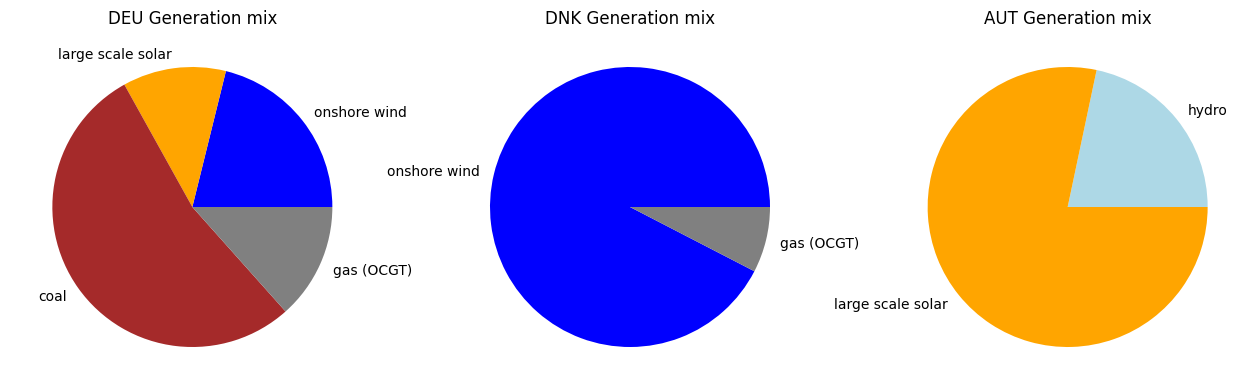

In [195]:
plt.figure(figsize=(16, 4))
plt.title(f'Generation mix for Germany, Denmark and Austria with {CO2_limit} MtCO2 limit', fontsize=16)
colors_all = {'onshore wind': 'blue',
               'offshore wind': 'darkblue',
               'large scale solar': 'orange',
               'rooftop solar': 'yellow',
               'coal': 'brown',
               'gas (OCGT)': 'grey',
               'hydro': 'lightblue'}


for country in countries:      
   if country == "DEU":
      labels = ['onshore wind',
               'offshore wind',
               'large scale solar',
               'coal',
               'gas (OCGT)']
      sizes = [n.generators_t.p[f'onshorewind{country}'].sum(),
                     n.generators_t.p[f'offshorewind{country}'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                     n.generators_t.p[f'coal{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]
      labels = [labels[i] for i in range(len(labels)) if sizes[i] > 0]
      sizes = [x for x in sizes if x > 0]
      colors = [colors_all[label] for label in labels]



      plt.subplot(1, 3, 1)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)
   
   if country == "DNK":
      labels = ['onshore wind',
               'offshore wind',
               'large scale solar',
               'gas (OCGT)']
      sizes = [n.generators_t.p[f'onshorewind{country}'].sum(),
                     n.generators_t.p[f'offshorewind{country}'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]

      labels = [labels[i] for i in range(len(labels)) if sizes[i] > 0]
      sizes = [x for x in sizes if x > 0]
      print(labels[0])
      colors = [colors_all[label] for label in labels]

      plt.subplot(1, 3, 2)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)

   
   if country == "AUT":
      labels = ['hydro',
               'large scale solar',
               'gas (OCGT)']
      sizes = [n.storage_units_t.p['hydroAUT'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]

      labels = [labels[i] for i in range(len(labels)) if sizes[i] > 0]
      sizes = [x for x in sizes if x > 0]
      colors = [colors_all[label] for label in labels]

      plt.subplot(1, 3, 3)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)

      


<AxesSubplot: xlabel='snapshot'>

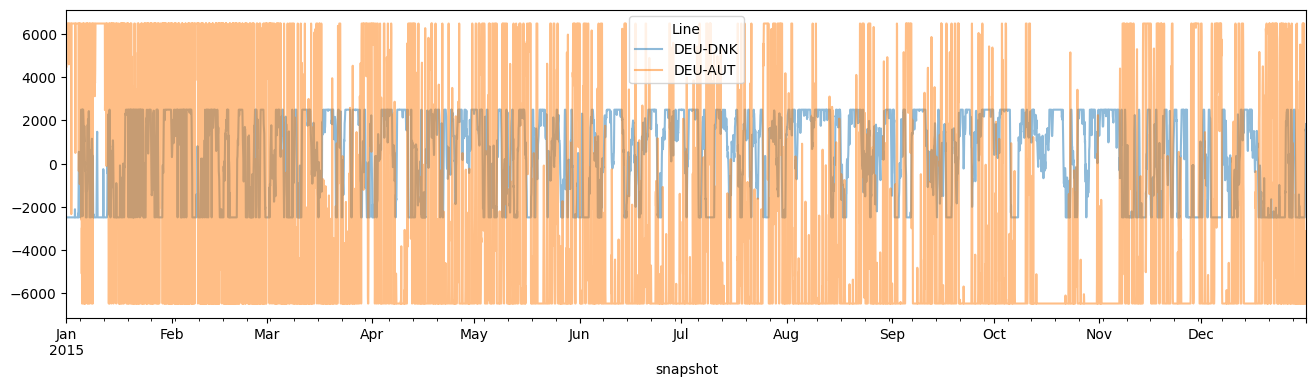

In [196]:
n.lines_t.p0.plot(figsize=(16, 4), alpha=0.5)